Demo - Increasing Seen Combinations

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Spandan-Madan/generalization_biased_category_pose/blob/main/demos/increasing_seen_combinations.ipynb)

In [1]:
import os
def create_folder(path):
    if not os.path.isdir(path):
        os.mkdir(path)

In [2]:
if 'google.colab' in str(get_ipython()):
    print('Cloning code base to colab....')
    !git clone https://github.com/Spandan-Madan/generalization_biased_category_pose.git
    create_folder('generalization_biased_category_pose/data')
    create_folder('generalization_biased_category_pose/data/mnist_rotation_data')
    print('Downloading MNIST Rotation Dataset....')
    !wget https://www.dropbox.com/s/wdws3b3fjo190sk/self_generated.tar.gz?dl=0 -O generalization_biased_category_pose/data/mnist_rotation_data/self_generated.tar.gz
    print('Unzipping data')
    !cd generalization_biased_category_pose/data/mnist_rotation_data/ && tar -zxf self_generated.tar.gz
    CODE_ROOT = 'generalization_biased_category_pose'
else:
    CODE_ROOT = '..'

In [3]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
from PIL import ImageFile
import random
ImageFile.LOAD_TRUNCATED_IMAGES = True
import argparse
import pickle
import sys
sys.path.append('%s/res/'%CODE_ROOT)
from models.models import get_model
from loader.loader import get_loader

/net/storage001.ib.cluster/om2/user/smadan/generalization_biased_category_pose/demos
../res/loader/multi_attribute_loader.py
../res/loader
../res/loader/loader.py
../res/loader


In [4]:
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
sns.set_palette("Set1", 8, .75)
sns.despine()

<Figure size 432x288 with 0 Axes>

In [29]:
DATASET_NAMES = ['mnist_rotation_one_by_nine', 'mnist_rotation_three_by_nine',
                 'mnist_rotation_six_by_nine', 'mnist_rotation_nine_by_nine']
NUM_EPOCHS = 10
BATCH_SIZE = 200
ARCH = 'LATE_BRANCHING_COMBINED'

image_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])


GPU = 1

In [30]:
NUM_CLASSES = (10,10,10,10)
loader_new = get_loader('multi_attribute_loader_file_list_mnist_rotation')

file_list_root = '%s/dataset_lists/'%CODE_ROOT
att_path = '%s/dataset_lists/combined_attributes.p'%CODE_ROOT

In [31]:
shuffles = {'train':True,'val':True,'test':False}

In [32]:
data_dir = '%s/data/'%CODE_ROOT

In [33]:
################ GET FROM USER CONFIG - TODO #####################
all_dsets = {}
all_dset_loaders = {}
all_dset_sizes = {}

for DATASET_NAME in DATASET_NAMES:
    file_lists = {}
    dsets = {}
    dset_loaders = {}
    dset_sizes = {}
    for phase in ['train','val','test']:
        file_lists[phase] = "%s/%s_list_%s.txt"%(file_list_root,phase,DATASET_NAME)
        dsets[phase] = loader_new(file_lists[phase],att_path, image_transform, data_dir)
        dset_loaders[phase] = torch.utils.data.DataLoader(dsets[phase], batch_size=BATCH_SIZE, shuffle = shuffles[phase], num_workers=2,drop_last=True)
        dset_sizes[phase] = len(dsets[phase])
    all_dsets[DATASET_NAME] = dsets
    all_dset_loaders[DATASET_NAME] = dset_loaders
    all_dset_sizes[DATASET_NAME] = dset_sizes

In [21]:
multi_losses = [nn.CrossEntropyLoss(),nn.CrossEntropyLoss(),nn.CrossEntropyLoss(),nn.CrossEntropyLoss()]

In [22]:
def weight_scheduler(epoch_num, task):
    if task == 'shared':
        return [0.0,1.0,0.0,1.0]
    elif task == 'viewpoint':
        return [0.0,1.0,0.0,0.0]
    elif task == 'category':
        return [0.0,0.0,0.0,1.0]

In [23]:
def train_epoch(dset_loaders, dset_sizes, model, task, optimizer):
    model.train()
    torch.set_grad_enabled(True)
    phase = 'train'
    
    weights = weight_scheduler(epoch, task)
    iters = 0
    phase_epoch_corrects = [0,0,0,0]
    phase_epoch_loss = 0
    
    for data in dset_loaders[phase]:
        inputs, labels_all, paths = data
        inputs = Variable(inputs.float().cuda())

        optimizer.zero_grad()
        model_outs = model(inputs)
        calculated_loss = 0
        batch_corrects = [0,0,0,0]
        
        for i in range(4):
            labels = labels_all[:,i]
            if GPU:
                labels = Variable(labels.long().cuda())
            loss = multi_losses[i]
            outputs = model_outs[i]
            calculated_loss += weights[i] * loss(outputs,labels)
            _, preds = torch.max(outputs.data, 1)
            batch_corrects[i] = torch.sum(preds == labels.data)
            phase_epoch_corrects[i] += batch_corrects[i]

        
        phase_epoch_loss += calculated_loss
        calculated_loss.backward()
        optimizer.step()
        iters += 1
    epoch_loss = phase_epoch_loss/dset_sizes[phase]
    # print('Train loss:%s'%epoch_loss)
    epoch_accs = [float(i)/dset_sizes[phase] for i in phase_epoch_corrects]

    if task == 'shared':
        epoch_gm = np.sqrt(epoch_accs[1] * epoch_accs[3])
    elif task == 'viewpoint':
        epoch_gm = epoch_accs[1]
    elif task == 'category':
        epoch_gm = epoch_accs[3]
    
    return model, epoch_loss, epoch_gm

In [24]:
def test_epoch(dset_loaders, dset_sizes, model, best_model, best_test_loss, best_test_gm, task):
    model.eval()
    torch.set_grad_enabled(False)
    phase = 'val'
    weights = weight_scheduler(epoch, task)
    iters = 0
    phase_epoch_corrects = [0,0,0,0]
    phase_epoch_loss = 0
    
    for data in dset_loaders[phase]:
        inputs, labels_all, paths = data
        inputs = Variable(inputs.float().cuda())
        model_outs = model(inputs)
        calculated_loss = 0
        batch_corrects = [0,0,0,0]
        
        for i in range(4):
            labels = labels_all[:,i]
            if GPU:
                labels = Variable(labels.long().cuda())
            loss = multi_losses[i]
            outputs = model_outs[i]
            calculated_loss += weights[i] * loss(outputs,labels)
            _, preds = torch.max(outputs.data, 1)
            batch_corrects[i] = torch.sum(preds == labels.data)
            phase_epoch_corrects[i] += batch_corrects[i]


        phase_epoch_loss += calculated_loss
        iters += 1
    epoch_loss = phase_epoch_loss/dset_sizes[phase]
    # print('Test loss:%s'%epoch_loss)
    epoch_accs = [float(i)/dset_sizes[phase] for i in phase_epoch_corrects]
    
    if task == 'shared':
        epoch_gm = np.sqrt(epoch_accs[1] * epoch_accs[3])
    elif task == 'viewpoint':
        epoch_gm = epoch_accs[1]
    elif task == 'category':
        epoch_gm = epoch_accs[3]
    
    if epoch_loss < best_test_loss:
        best_model = model
        best_test_loss = epoch_loss
        best_test_gm = epoch_gm
    
    return best_model, epoch_loss, epoch_gm, best_test_loss, best_test_gm

In [25]:
def unseen_test_epoch(dset_loaders, dset_sizes, model, task):
    model.eval()
    torch.set_grad_enabled(False)
    phase = 'test'

    weights = weight_scheduler(epoch, task)
    iters = 0
    phase_epoch_corrects = [0,0,0,0]
    phase_epoch_loss = 0
    
    for data in dset_loaders[phase]:
        inputs, labels_all, paths = data
        inputs = Variable(inputs.float().cuda())
        model_outs = model(inputs)
        calculated_loss = 0
        batch_corrects = [0,0,0,0]
        
        for i in range(4):
            labels = labels_all[:,i]
            if GPU:
                labels = Variable(labels.long().cuda())
            loss = multi_losses[i]
            outputs = model_outs[i]
            calculated_loss += weights[i] * loss(outputs,labels)
            _, preds = torch.max(outputs.data, 1)
            batch_corrects[i] = torch.sum(preds == labels.data)
            phase_epoch_corrects[i] += batch_corrects[i]


        phase_epoch_loss += calculated_loss
        iters += 1
    epoch_loss = phase_epoch_loss/dset_sizes[phase]
    epoch_accs = [float(i)/dset_sizes[phase] for i in phase_epoch_corrects]
    
    if task == 'shared':
        epoch_gm = np.sqrt(epoch_accs[1] * epoch_accs[3])
    elif task == 'viewpoint':
        epoch_gm = epoch_accs[1]
    elif task == 'category':
        epoch_gm = epoch_accs[3]
    
    return epoch_loss, epoch_gm

In [15]:
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

In [26]:
DATASET_NAMES

{'mnist_rotation_nine_by_nine',
 'mnist_rotation_one_by_nine',
 'mnist_rotation_six_by_nine',
 'mnist_rotation_three_by_nine'}

In [28]:
dataset_titles = {}
dataset_titles['mnist_rotation_one_by_nine'] = "10% combinations seen"
dataset_titles['mnist_rotation_three_by_nine'] = "30% combinations seen"
dataset_titles['mnist_rotation_six_by_nine'] = "60% combinations seen"
dataset_titles['mnist_rotation_nine_by_nine'] = "90% combinations seen"

Epoch: 0
---------


<ipython-input-40-b0e0c330c0a5>:84: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2],     # The line objects


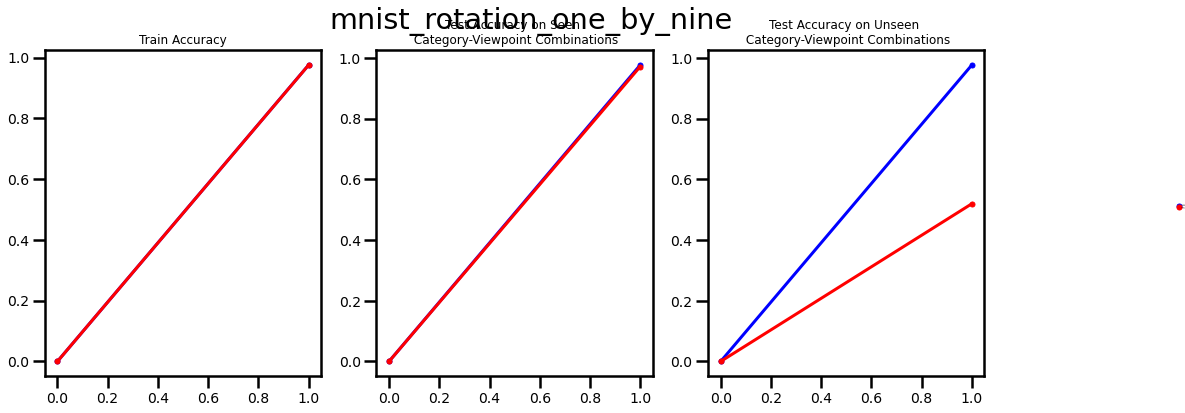

Epoch: 1, Task: viewpoint
---------


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, Task: category
---------


  0%|          | 0/250 [00:00<?, ?it/s]

In [ ]:
for DATASET_NAME in DATASET_NAMES:
    dsets = all_dsets[DATASET_NAME]
    dset_loaders = all_dset_loaders[DATASET_NAME]
    dset_sizes = all_dset_sizes[DATASET_NAME]
    
    models = {}

    models['shared']= get_model(ARCH,NUM_CLASSES)
    models['viewpoint']= get_model(ARCH,NUM_CLASSES)
    models['category']= get_model(ARCH,NUM_CLASSES)

    models['shared'].cuda();
    models['viewpoint'].cuda();
    models['category'].cuda();

    best_models = {}
    best_models['shared'] = models['shared']
    best_models['viewpoint'] = models['viewpoint']
    best_models['category'] = models['category']

    best_test_loss = 100
    best_test_gm = 0

    all_train_gms = {}
    all_train_gms['shared'] = [0]
    all_train_gms['separate'] = [0]

    all_test_gms = {}
    all_test_gms['shared'] = [0]
    all_test_gms['separate'] = [0]

    all_unseen_test_gms = {}
    all_unseen_test_gms['shared'] = [0]
    all_unseen_test_gms['separate'] = [0]

    optimizers = {}
    optimizers['shared'] = optim.Adam(models['shared'].parameters(), lr=0.001)
    optimizers['viewpoint'] = optim.Adam(models['viewpoint'].parameters(), lr=0.001)
    optimizers['category'] = optim.Adam(models['category'].parameters(), lr=0.001)
    for epoch in tqdm(range(5)):
        train_gm_separate = 1
        test_gm_separate = 1
        unseen_test_gm_separate = 1

        for TASK in ['viewpoint','category','shared']:
            print('Epoch: %s, Task: %s'%(epoch,TASK))
            print('---------')
            models[TASK], train_loss, train_gm = train_epoch(dset_loaders, dset_sizes, models[TASK], TASK, optimizers[TASK])
            best_models[TASK], test_loss, test_gm, best_test_loss, best_test_gm = test_epoch(dset_loaders, dset_sizes, models[TASK], best_models[TASK], best_test_loss, best_test_gm, TASK)
            unseen_test_loss, unseen_test_gm = unseen_test_epoch(dset_loaders, dset_sizes, models[TASK], TASK)

            if TASK != 'shared':
                train_gm_separate = train_gm_separate * train_gm
                test_gm_separate = test_gm_separate * test_gm
                unseen_test_gm_separate = unseen_test_gm_separate * test_gm

        all_train_gms['separate'].append(np.sqrt(train_gm_separate))
        all_test_gms['separate'].append(np.sqrt(test_gm_separate))
        all_unseen_test_gms['separate'].append(np.sqrt(unseen_test_gm_separate))
        all_train_gms['shared'].append(train_gm)
        all_test_gms['shared'].append(test_gm)
        all_unseen_test_gms['shared'].append(np.sqrt(unseen_test_gm))

    fig,ax = plt.subplots(1, 3, figsize=(18,6))
    fig.suptitle(dataset_titles[DATASET_NAME], fontsize = 30)
    l1 = ax[0].plot(all_train_gms['separate'], color = 'blue', marker = 'o', markersize=5)[0]
    l2 = ax[0].plot(all_train_gms['shared'], color = 'red', marker = 'o', markersize=5)[0]
    ax[0].set_title('Train Accuracy', fontsize=12)
    line_labels = ["Separate", "Shared"]

    ax[1].plot(all_test_gms['separate'], color = 'blue', marker = 'o', markersize=5)
    ax[1].plot(all_test_gms['shared'], color = 'red', marker = 'o', markersize=5)
    ax[1].set_title('Test Accuracy on Seen \n Category-Viewpoint Combinations', fontsize=12)

    ax[2].plot(all_unseen_test_gms['separate'], color = 'blue', marker = 'o', markersize=5)
    ax[2].plot(all_unseen_test_gms['shared'], color = 'red', marker = 'o', markersize=5)
    ax[2].set_title('Test Accuracy on Unseen \n Category-Viewpoint Combinations', fontsize=12)
    fig.legend([l1, l2],     # The line objects
            labels=line_labels,   # The labels for each line
            loc="center right",   # Position of legend
            borderaxespad=0.2,    # Small spacing around legend box
            prop={"size":20})
    plt.subplots_adjust(right=0.85, top =0.80)
    plt.show()